In [1]:
from IPython.core.display import HTML
import requests
import re

import matplotlib.pylab as plt
from astropy import units as u

In [2]:
# WebPIMMS request, deduced from web application requests

def webpimms_flux(e1: float, e2: float):
    t = requests.post("https://heasarc.gsfc.nasa.gov/cgi-bin/Tools/w3pimms/w3pimms.pl",
                  data={
                      "from": "INTEGRAL/ISGRI Count Rate",
                      "sat": "FLUX",
                      "range": f"{e1}-{e2}",
                      "etype": "kev",
                      "orange": f"{e1}-{e2}",
                      "otype": "kev",
                      "flusso": 1,
                      "nh": 0,
                      "red": "none",
                      "nhi": "none",
                      "model": "Power Law",
                      "gama": 2,
                      "solar": "1.0 Solar Abundance",
                  }
                 ).text      

    return float(re.search("PIMMS predicts a flux .*? of (.*?) ergs/cm/cm/s", t).groups()[0])

#HTML(t)


webpimms_flux(40,80)

7.522e-11

In [3]:
# query crab spectra and responses

from astroquery.simbad import Simbad
import numpy as np
from astropy.coordinates import SkyCoord

result_table = Simbad.query_object("Crab")

c = SkyCoord(result_table['RA'][0], result_table['DEC'][0], unit=("hourangle", "deg"))



from oda_api.api import DispatcherAPI

products_for_src = lambda o, name: { 
        v.meta_data['product']:v 
            for k,v in o.__dict__.items() 
            if getattr(v,'meta_data',{}).get('src_name') == name
    }



disp=DispatcherAPI(host="https://www.astro.unige.ch/cdci/astrooda/dispatch-data")

T1_2osa_utc="2016-01-01T00:00:00"
T2_2osa_utc="2017-01-01T00:00:00"


spec_data_osa10=disp.get_product(instrument='isgri',
                    product='isgri_spectrum',
                    T1=T1_2osa_utc,
                    T2=T2_2osa_utc,
                    query_type='Real',
                    osa_version='OSA10.2',
                    RA=c.ra.deg,
                    DEC=c.dec.deg,
                    product_type='Real',
                    #selected_catalog=api_cat
                    )

spec_data_osa11=disp.get_product(instrument='isgri',
                    product='isgri_spectrum',
                    T1=T1_2osa_utc,
                    T2=T2_2osa_utc,
                    query_type='Real',
                    osa_version='OSA11.0',
                    RA=c.ra.deg,
                    DEC=c.dec.deg,
                    product_type='Real',
                    #selected_catalog=api_cat,
                    )



- waiting for remote response, please wait run_analysis https://www.astro.unige.ch/cdci/astrooda/dispatch-data
T1 2016-01-01T00:00:00
T2 2017-01-01T00:00:00
query_type Real
osa_version OSA10.2
RA 83.63308333333332
DEC 22.0145
instrument isgri
product_type isgri_spectrum
off_line (False,)
query_status ('new',)
verbose (False,)
session_id MNEZ8BPOH5VX9RXX
dry_run (False,)
api True
oda_api_version 1.0.1


query done succesfully!
- waiting for remote response, please wait run_analysis https://www.astro.unige.ch/cdci/astrooda/dispatch-data
T1 2016-01-01T00:00:00
T2 2017-01-01T00:00:00
query_type Real
osa_version OSA11.0
RA 83.63308333333332
DEC 22.0145
instrument isgri
product_type isgri_spectrum
off_line (False,)
query_status ('new',)
verbose (False,)
session_id VBE5J7F8CMLAO2OA
dry_run (False,)
api True
oda_api_version 1.0.1


query done succesfully!


--> NAME PRIMARY
--> NAME GROUPING
--> NAME SPECRESP MATRIX
--> NAME EBOUNDS
--> NAME PRIMARY
--> NAME GROUPING
--> NAME SPECRESP MATRIX
--> NAME EBOUNDS
flux_eband 7.496672168974315e-09
response norm in 20 40 is 144.07974 rate norm 136.2734 erg/cm2 per count 5.203141012367613e-11
--> NAME PRIMARY
--> NAME EBOUNDS
--> NAME SPECRESP MATRIX
--> NAME PRIMARY
--> NAME EBOUNDS
--> NAME SPECRESP MATRIX
flux_eband 7.496672168974315e-09
response norm in 20 40 is 189.04135 rate norm 209.77065 erg/cm2 per count 3.9656255717032905e-11
--> NAME PRIMARY
--> NAME GROUPING
--> NAME SPECRESP MATRIX
--> NAME EBOUNDS
--> NAME PRIMARY
--> NAME GROUPING
--> NAME SPECRESP MATRIX
--> NAME EBOUNDS
flux_eband 4.234415147439787e-09
response norm in 40 60 is 43.463947 rate norm 37.25743 erg/cm2 per count 9.742362143476073e-11
--> NAME PRIMARY
--> NAME EBOUNDS
--> NAME SPECRESP MATRIX
--> NAME PRIMARY
--> NAME EBOUNDS
--> NAME SPECRESP MATRIX
flux_eband 4.234415147439787e-09
response norm in 40 60 is 78.76468 ra

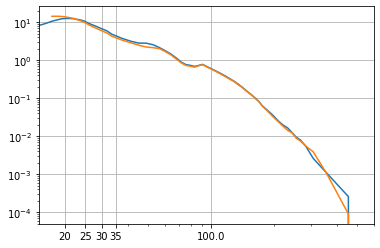

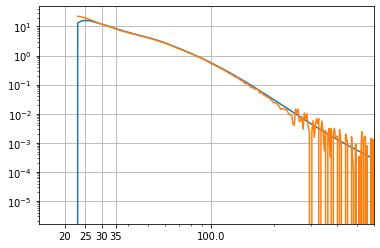

In [4]:
def extra_ticks(et):
    ax = plt.gca()
    tx = ax.get_xticks()
    ax.set_xticks(
        list(tx)+et
    )
    ax.set_xticklabels(
        list(tx)+et
    )

    
    

# Roques & Jourdain 2018
def crab_ph_cm2_s_kev(en):
    K=7.417e-4
    al1=-1.98
    al2=-2.33
    Ec=500.
    f=K*(en/100)**al1*(np.exp(-en/Ec))
    m=en>Ec*(al1-al2)
    f[m]=(K*((al1-al2)*Ec/100)**(al1-al2)*(en/100)**al2*np.exp(-(al1-al2)))[m]

    return f

def resp_norm(D, e1, e2, plot=False):
    p = products_for_src(D, 'Crab')
    
    arf=p['isgri_arf'].data_unit[1].data
    rmf_eb=p['isgri_rmf'].get_data_unit_by_name('EBOUNDS').data
    rmf_mt=p['isgri_rmf'].get_data_unit_by_name('SPECRESP MATRIX').data
    spec=p['isgri_spectrum'].data_unit[1]
    
    crab_ph_cm2_s_kev    
    ie1=arf['ENERG_LO']
    ie2=arf['ENERG_HI']
    
    source=crab_ph_cm2_s_kev(ie1)
    
    m_flux = (ie1>e1) & (ie2<=e2)
    flux_erg_cm2_s_eband = np.nansum((source*(ie2-ie1)*ie1)[m_flux])*((1.*u.keV).to(u.erg).value)
    
    print("flux_eband", flux_erg_cm2_s_eband)
    
    
    csource=np.outer(arf['SPECRESP']*source*(ie2-ie1),np.ones_like(rmf_eb['E_MIN']))*rmf_mt['MATRIX']
        
    
    if plot:
        plt.figure()
        plt.plot(
            rmf_eb['E_MIN'],
            csource.sum(0)/(rmf_eb['E_MAX']-rmf_eb['E_MIN'])
        )
        
        plt.plot(
            rmf_eb['E_MIN'],
            spec.data['RATE']/(rmf_eb['E_MAX']-rmf_eb['E_MIN'])
        )
        
        plt.loglog()
        
        extra_ticks(
            [20,25,30,35]
        )
        
        plt.xlim([15, 600])
        plt.grid()

    rate_n = np.nansum(spec.data['RATE'][(rmf_eb['E_MIN']>e1) & (rmf_eb['E_MAX']<e2)])

    n = csource[:,(rmf_eb['E_MIN']>e1) & (rmf_eb['E_MAX']<e2)].sum()
    
    erg_cm2_per_count = flux_erg_cm2_s_eband/n
    
    print("response norm in", e1,e2,"is",n, "rate norm", rate_n, "erg/cm2 per count", erg_cm2_per_count)

    return erg_cm2_per_count


erg_cm2_per_count = []
    
plot=True
for e1,e2 in [
    (20, 40),
    (40, 60),
    (60, 100),
]:
    for origin, c in [
        ('osa10', resp_norm(spec_data_osa10, e1, e2, plot=plot)),
        ('osa11', resp_norm(spec_data_osa11, e1, e2, plot=plot)),
        ('pimms', webpimms_flux(e1,e2))
    ]:    
        erg_cm2_per_count.append(dict(
            e1=e1,
            e2=e2,
            origin=origin,
            erg_cm2_in_count=c,
        ))
    
    plot=False


In [5]:
import json

json.dump(
    erg_cm2_per_count,
    open("conversions.json", "wt")
)

In [6]:
!cat conversions.json | jq

[
  {
    "e1": 20,
    "e2": 40,
    "origin": "osa10",
    "erg_cm2_in_count": 5.203141012367613e-11
  },
  {
    "e1": 20,
    "e2": 40,
    "origin": "osa11",
    "erg_cm2_in_count": 3.9656255717032905e-11
  },
  {
    "e1": 20,
    "e2": 40,
    "origin": "pimms",
    "erg_cm2_in_count": 4.597e-11
  },
  {
    "e1": 40,
    "e2": 60,
    "origin": "osa10",
    "erg_cm2_in_count": 9.742362143476073e-11
  },
  {
    "e1": 40,
    "e2": 60,
    "origin": "osa11",
    "erg_cm2_in_count": 5.376033018372107e-11
  },
  {
    "e1": 40,
    "e2": 60,
    "origin": "pimms",
    "erg_cm2_in_count": 6.188e-11
  },
  {
    "e1": 60,
    "e2": 100,
    "origin": "osa10",
    "erg_cm2_in_count": 1.480224033594071e-10
  },
  {
    "e1": 60,
    "e2": 100,
    "origin": "osa11",
    "erg_cm2_in_count": 9.400677917232613e-11
  },
  {
    "e1": 60,
    "e2": 100,
    "origin": "pimms",
    "erg_cm2_in_count": 1.233e-10
  }
]


In [20]:
import pandas as pd

rdiff_pc = lambda x,ax: (100*(ax-x)/ax)

for (e1,e2), v in pd.DataFrame(erg_cm2_per_count).groupby(['e1', 'e2']):
    bo = dict(list(v.groupby('origin')))
    print("{} {} osa11 vs pimms {:.1f}% osa11 - osa10 {:.1f}%  osa10 - pimms {:.1f}%".format(e1, e2, 
          rdiff_pc(bo['osa11'].erg_cm2_in_count.iloc[0], bo['pimms'].erg_cm2_in_count.iloc[0]),
          rdiff_pc(bo['osa11'].erg_cm2_in_count.iloc[0], bo['osa10'].erg_cm2_in_count.iloc[0]),
          rdiff_pc(bo['osa10'].erg_cm2_in_count.iloc[0], bo['pimms'].erg_cm2_in_count.iloc[0]),
         ))

20 40 osa11 vs pimms 13.7% osa11 - osa10 23.8%  osa10 - pimms -13.2%
40 60 osa11 vs pimms 13.1% osa11 - osa10 44.8%  osa10 - pimms -57.4%
60 100 osa11 vs pimms 23.8% osa11 - osa10 36.5%  osa10 - pimms -20.1%
